In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import string
# from string import punctuation
# from itertools import chain

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, f_classif

# from sklearn import svm
from sklearn.utils import shuffle

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk import ngrams

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns
! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

## Loading dataset and exploration

In [114]:
df = pd.read_csv('AmazonReviews.csv')

In [115]:
df.columns

Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote'],
      dtype='object')

In [116]:
df.shape

(551159, 14)

In [117]:
print(df.isnull().sum())

userName         133
verified           0
itemName           1
description        8
image              0
brand           3872
feature            0
category           0
price          74334
rating             0
reviewTime         0
summary          243
reviewText       428
vote               0
dtype: int64


In [118]:
df.head()

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0


In [119]:
pos = df[df['rating']>3]
neg = df[df['rating']<3]
print(pos.shape, neg.shape)

(453086, 14) (57434, 14)


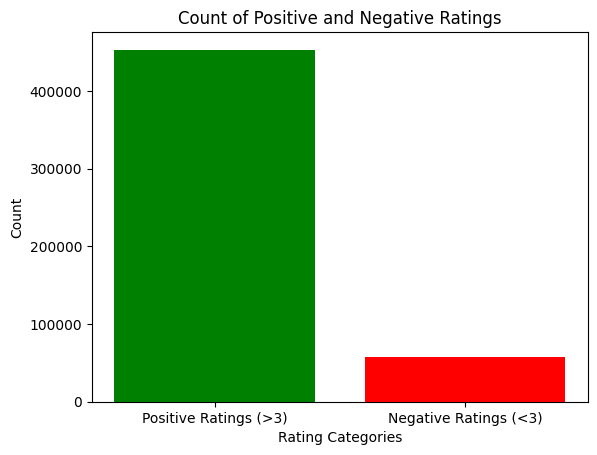

In [120]:
counts = [pos.shape[0], neg.shape[0]]

# Create a bar chart
plt.bar(['Positive Ratings (>3)', 'Negative Ratings (<3)'], counts, color=['green', 'red'])
plt.title('Count of Positive and Negative Ratings')
plt.ylabel('Count')
plt.xlabel('Rating Categories')
plt.show()

## Adding sentiment values:
- Done via a sentiment map
- resulting column added to original dataframe

In [121]:
sentiment_map = {1:0, 2:0, 4:1, 5:1}

temp = df[df['rating'] != 3]
y = df['rating'].map(sentiment_map)

df['sentiment'] = y

In [122]:
df.head()

,userName,verified,itemName,description,image,brand,feature,category,price,rating,reviewTime,summary,reviewText,vote,sentiment
0,Amazon Customer,True,"Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...","[""Made from deliciously decadent ingredients, ...",['https://images-na.ssl-images-amazon.com/imag...,Toblerone,[],Prime_Pantry,$1.63,5.0,2018-01-01,Five Stars,super smooth and yummy with crunchy bits,0,1.0
1,Carla,True,"Prince of Peace Organic Tea, Oolong, 100 Tea Bags","['Prince of Peace Enterprises, Inc., founded i...",['https://images-na.ssl-images-amazon.com/imag...,Prince Of Peace,[],Grocery_and_Gourmet_Food,$6.40,5.0,2018-01-01,Five Stars,Perfect for kombucha,0,1.0
2,Jaclyn,True,"Pet Champion Adjustable No-Pull Harness, Colla...","[""The Pet Champion Large/ Extra Large 22-36 in...",['https://images-na.ssl-images-amazon.com/imag...,Pet Champion,"['Features Bright Pink Lemonade pattern', 'Dua...",Pet_Supplies,$7.99,5.0,2018-01-01,she has an odd shape chest and her pull over h...,Finally a harness that fits my puppy. I really...,0,1.0
3,Christinne M,False,Koh-I-Noor Progresso Woodless Colored 24-Penci...,['Koh-I-Noor Progresso Woodless Colored 24-Pen...,['https://images-na.ssl-images-amazon.com/imag...,KOH-I-NOOR,"['Rich, pigmented, solid color encased in lacq...",Arts_Crafts_and_Sewing,$14.18,5.0,2018-01-01,Loving!!,I LOVE THEM!! I bought them at Micheals our of...,0,1.0
4,Sandy,True,"Parker Urban Premium Ebony Metal Chiseled, Bal...","[""Stunning craftsmanship based on a classic st...",['https://images-na.ssl-images-amazon.com/imag...,Parker,['Ebony black with metallic highlights and a g...,Office_Products,NaN,5.0,2018-01-01,I love this pen,"I love this pen! I love the shape of it, the f...",0,1.0


## Preparing dataframe for preprocessing

In [123]:
reviews_to_clean = pd.DataFrame()
reviews_to_clean = df['reviewText']

summary_to_clean = pd.DataFrame()
summary_to_clean = df['summary']

In [124]:
print(reviews_to_clean.head(5))

0             super smooth and yummy with crunchy bits
1                                 Perfect for kombucha
2    Finally a harness that fits my puppy. I really...
3    I LOVE THEM!! I bought them at Micheals our of...
4    I love this pen! I love the shape of it, the f...
Name: reviewText, dtype: object


In [125]:
print(summary_to_clean.head(5))

0                                           Five Stars
1                                           Five Stars
2    she has an odd shape chest and her pull over h...
3                                             Loving!!
4                                      I love this pen
Name: summary, dtype: object


In [126]:
print(type(reviews_to_clean))
print(type(summary_to_clean))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [127]:
print(reviews_to_clean.shape)
print(summary_to_clean.shape)

(551159,)
(551159,)


In [128]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/gitpod/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gitpod/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [129]:
stop_words = stopwords.words('english')
# print(stop_words)

## Cleaning HTML aspects
- includes tags and https:// 

In [130]:
def clean_html(text):
    # Remove URLs
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub('<.*?>+', '', text)
    return text

## Creating tokens

In [131]:
def tokenize_df(text):
    if isinstance(text, str):  # If the input is a string
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token.isalpha()]  # Keep only alphabetic tokens
        return tokens
    elif isinstance(text, (int, float)):  # If the input is an integer or float
        return text  # Return the number as is
    else:
        return []

## Removing stopwords

In [132]:
def remove_stopwords(tokens):
    stop_words = (stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

## Lemmatization:
- Spelling or semantics of words may have been affected via tokenisation or punctuation removal. This was done to try to preserve value of those that may have been affected

In [133]:
# def lemmatize_text(tokens):
#     lemma = WordNetLemmatizer()
#     lemma_token = [lemma.lemmatize(word) for word in tokens]
#     return lemma_token

def lemmatize_text(tokens):
    if tokens is None:
        return []  # Return an empty list if tokens is None
    lemma = WordNetLemmatizer()
    lemma_tokens = [lemma.lemmatize(word) for word in tokens if word is not None]  # Check for None
    return lemma_tokens

## Cleaning text utilizing prior functions

In [134]:
def clean_text(text):
    if not isinstance(text, str):  # Check if the input is not a string
        return ''  # Return an empty string or handle it as needed
    text = clean_html(text)
    tokens = tokenize_df(text)
    tokens = [token.lower() for token in tokens]
    tokens = remove_stopwords(tokens)
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    tokens = lemmatize_text(tokens)
    return ' '.join(tokens)

In [135]:
cleaned_reviews = reviews_to_clean.apply(clean_text)
# cleaned_summary = summary_to_clean.apply(clean_text)

In [136]:
cleaned_reviews.head()

0                       super smooth yummy crunchy bit
1                                     perfect kombucha
2    finally harness fit puppy really need harness ...
3    love bought micheals curiosity wanting try dif...
4    love pen love shape feel weight color highly r...
Name: reviewText, dtype: object

## Convert all instances of float or integer data to string:
- This was done to avoid instances of float or integer.
- Chose not to drop the values since it may hold value in our analysis

In [137]:
cleaned_reviews.apply(lambda x: re.sub(r"\s+", " ", x).strip()if isinstance(x, str) else x)

0                            super smooth yummy crunchy bit
1                                          perfect kombucha
2         finally harness fit puppy really need harness ...
3         love bought micheals curiosity wanting try dif...
4         love pen love shape feel weight color highly r...
                                ...                        
551154                               cheap price weak chain
551155                                       great deck box
551156    putting weather station anticipate problem kee...
551157    nice quality grilling table put grilling stuff...
551158                       nice variety pack whole family
Name: reviewText, Length: 551159, dtype: object

In [138]:
cleaned_summary.apply(lambda x: re.sub(r"\s+", " ", x).strip()if isinstance(x, str) else x)

0                                                 five star
1                                                 five star
2         odd shape chest pull harness going big head ea...
3                                                    loving
4                                                  love pen
                                ...                        
551154                                             two star
551155                             deck box good investment
551156                                    keep old man roof
551157                   easy assemble work well next grill
551158                                 family love poptarts
Name: summary, Length: 551159, dtype: object

## Dropping values:
- This was done to account for any rows that had no data. Avoids NaN representation for text_fit

In [139]:
cleaned_reviews = cleaned_reviews.fillna('').astype(str)

In [140]:
print(cleaned_reviews.isnull().sum())

0


In [141]:
def print_cloud(data):
    text = " ".join(review for review in data)
    print ("There are {} words in the combination of all reviews.".format(len(text)))
    stopwords_set = set(stopwords.words('english'))
    wordcloud = WordCloud(stopwords=stopwords_set, background_color="white").generate(text)
    return wordcloud

## Visualisation
- Small visualisation to check if cleaning went as expected

There are 54532759 words in the combination of all reviews.


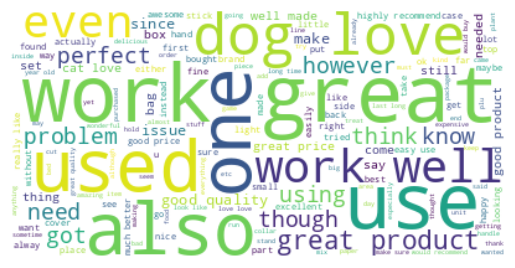

In [143]:
wordcloud = print_cloud(cleaned_reviews)
fig = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [144]:
X = cleaned_reviews
print(type(X))
print(X.shape)

<class 'pandas.core.series.Series'>
(551159,)


In [145]:
y = df['sentiment']
print(type(y))
print(y.shape)
print(y.isnull().sum()) 

<class 'pandas.core.series.Series'>
(551159,)
40639


## Dropping NaN 
- Dropped those rows with NaN representations in sentiments based on the assumption their rating was a 3/5. Justified since the data loss is negligible when compared to that which remains

In [146]:
y = y.dropna()
X = X[y.index] 
print(X.shape)
print(y.shape)

(510520,)
(510520,)


In [147]:
def text_fit(X, y, model, clf_model, coef_show=1):
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
    print ('Model Recall: {}'.format(recall))
    if coef_show == 1: 
        w = model.get_feature_names_out()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

## Interpretation
- A recall of approximately 0.99 indicates that the model is very effective at identifying positive sentiments in the reviews.
- The output lists the top 20 words (or n-grams) that are most strongly associated with positive sentiment, along with their coefficients.
- The words listed here are the strongest indicators of positive sentiment in the reviews. The coefficients represent the weight of each word in the logistic regression model.

In [148]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2), stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 2268711
# train records: 382890
# test records: 127630
Model Recall: 0.9913458563535912

-Top 20 positive-
            Word  Coefficient
           great    20.230047
            love    20.214720
         perfect    13.603012
       excellent    10.695125
            best    10.560789
       delicious    10.050529
            nice     9.999580
         amazing     9.881635
       perfectly     9.705045
            easy     8.707396
         awesome     8.628141
        favorite     7.827358
          easier     7.522538
       complaint     7.237981
       fantastic     6.830259
       wonderful     6.779819
         pleased     6.700629
highly recommend     6.680016
          highly     6.634692
       beautiful     6.494940

-Top 20 negative-
         Word  Coefficient
        sorry    -7.111149
  waste money    -7.129727
        threw    -7.145452
      garbage    -7.329550
       poorly    -7.395356
       refund    -7.576696
        worse    -7.625465
     returned   

## Usage of select percentile
- f_classif for classification tasks (ANOVA F-value between label/feature)
- Selecting only the most relevant features, it significantly reduces the dimensionality.
- Reduces overfitting, as the model will focus on the most informative features.
- Eliminating features that do not contribute significantly to the prediction, reduces the noise in the dataset; leads to better generalization on unseen data.

In [149]:
def text_fit_v2(X, y, model, clf_model, select_percentile_value, coef_show=1):
    X_c = model.fit_transform(X)
    print('# features before applying select percentile: {}'.format(X_c.shape[1]))
    select_percentile = SelectPercentile(score_func=f_classif, percentile=select_percentile_value)
    X_transformed = select_percentile.fit_transform(X_c, y)
    print('# features after applying select percentile: {}'.format(X_transformed.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test,y_pred)
    print ('Model Recall: {}'.format(recall))
    if coef_show == 1:
        idx = np.arange(0, X_c.shape[1])  #create an index array
        features_to_keep = idx[select_percentile.get_support() == True]
        cols = np.array(list(model.vocabulary_.keys()))
        w = cols[features_to_keep]
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))

In [157]:
tfidf_n = TfidfVectorizer(ngram_range=(1, 2), stop_words = 'english')
text_fit_v2(X, y, tfidf_n, LogisticRegression(), 25, 1)

# features before applying select percentile: 2268711
# features after applying select percentile: 567178
# train records: 382890
# test records: 127630
Model Recall: 0.9913370165745856

-Top 20 positive-
                 Word  Coefficient
    hotsauce dripping    20.774149
         cabinet scan    18.504783
            acted way    13.441121
       definitely toy    10.918197
    quarantine update    10.564083
           upper cost    10.344670
   deliciousness girl     9.422179
      stringing tower     9.199292
        perfect power     9.175123
  conditioner instead     9.115220
        renewal great     8.164402
       exercise hoped     7.805634
            come xbox     7.273848
warmer characteristic     7.101200
            tone pack     6.531496
        jumped return     6.412342
            bien mais     6.274132
         cheaper idea     6.165289
             play let     6.160846
       disc intrigued     6.035289

-Top 20 negative-
              Word  Coefficient
       tu

In [158]:
cleaned_reviews.head()

0                       super smooth yummy crunchy bit
1                                     perfect kombucha
2    finally harness fit puppy really need harness ...
3    love bought micheals curiosity wanting try dif...
4    love pen love shape feel weight color highly r...
Name: reviewText, dtype: object

In [159]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [160]:
from numpy import array
import tensorflow as tf

In [161]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM

In [162]:
cleaned_reviews.head(5)

0                       super smooth yummy crunchy bit
1                                     perfect kombucha
2    finally harness fit puppy really need harness ...
3    love bought micheals curiosity wanting try dif...
4    love pen love shape feel weight color highly r...
Name: reviewText, dtype: object

In [163]:
df['sentiment'].head(5)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: sentiment, dtype: float64

In [170]:
reviews = []
sentiments = []

reviews = cleaned_reviews
sentiments = df['sentiment']
sentiments = np.array(list(map(lambda x: 1 if x==1 else 0, sentiments)))

In [171]:
print(sentiments)

[1 1 1 ... 1 1 1]


In [172]:
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, 
                                                test_size=0.20, random_state=42)

In [173]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [174]:
import io
import json

In [175]:
tokenizer_json = word_tokenizer.to_json()
with io.open('embedded.json', 'w', encoding = 'utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [176]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

63246

In [177]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [178]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [179]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [180]:
embedding_matrix.shape

(63246, 100)

In [181]:
from keras.layers import LSTM

In [182]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], 
                    input_length=100, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

/home/gitpod/.pyenv/versions/3.9.10/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [183]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=['acc'])



In [184]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, 
                                        verbose=1,validation_split=0.2)

Epoch 1/6
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 352s 127ms/step - acc: 0.8211 - loss: 0.4731 - val_acc: 0.8437 - val_loss: 0.3567
Epoch 2/6
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 323s 117ms/step - acc: 0.8631 - loss: 0.3162 - val_acc: 0.8849 - val_loss: 0.2768
Epoch 3/6
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 317s 115ms/step - acc: 0.8897 - loss: 0.2660 - val_acc: 0.8908 - val_loss: 0.2622
Epoch 4/6
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 317s 115ms/step - acc: 0.8978 - loss: 0.2486 - val_acc: 0.8931 - val_loss: 0.2573
Epoch 5/6
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 305s 111ms/step - acc: 0.9053 - loss: 0.2332 - val_acc: 0.8954 - val_loss: 0.2532
Epoch 6/6
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 309s 112ms/step - acc: 0.9117 - loss: 0.2211 - val_acc: 0.8939 - val_loss: 0.2543


In [185]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

3445/3445 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - acc: 0.8946 - loss: 0.2544


In [186]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


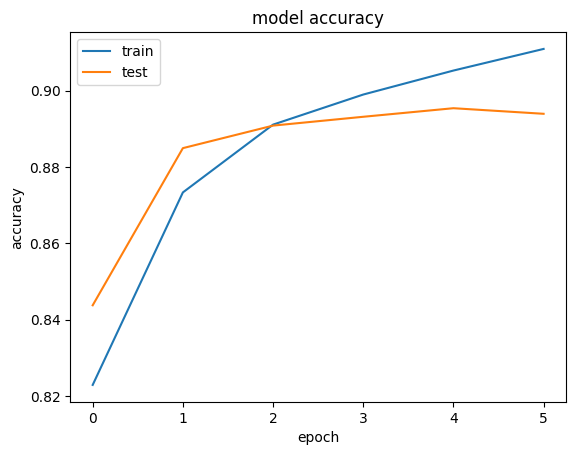

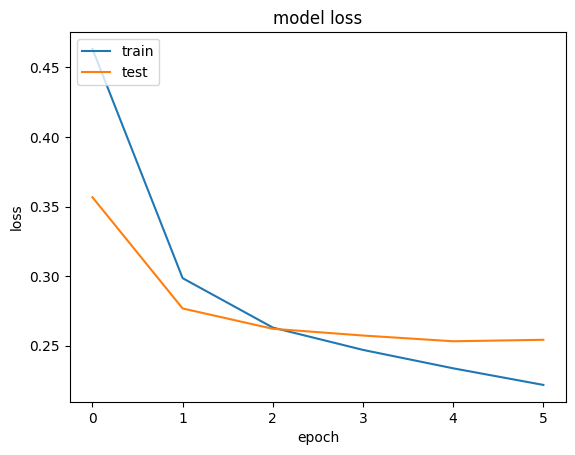

In [187]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()